In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
import numpy as np
import folium
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import requests

Import the neighborhoods coordinate data from the goverment data portal. The data is in Indonesian.
Explanation:
1. Kecamatan is the same as borough in US or Canada
2. Kelurahan is neighborhood in English or in US
3. Lintang Selatan means Southern Latitude (Bandung is in southern hempisphere and Indonesian is more familiar with the term rather than 'latitude')
4. Bujur Timur means Eastern Longitude (Indonesia is in the eastern of greenwich and again, we more familiar with the term)
5. Ketinggian means elevation from the sea level

In [2]:
geo_dat=pd.read_csv(r'C:\Users\ASUS\Downloads\koordinat-dan-ketinggian-kantor-kelurahan-di-kota-bandung-2014.csv')
geo_dat.head()

,Kecamatan,Kelurahan,Lintang Selatan,Bujur Timur,Ketinggian (dpl)
0,Bandung Kulon,Gempol Sari,-6.92911,107.55907,696
1,Bandung Kulon,Cigondewah Kaler,-6.93411,107.56361,700
2,Bandung Kulon,Cigondewah Kidul,-6.94386,107.56005,686
3,Bandung Kulon,Cigondewah Rahayu,-6.94889,107.56314,683
4,Bandung Kulon,Caringin,-6.92727,107.57698,702


The Ketinggian column will be dropped since the column is not relevant (every single place in Bandung has different elevation and Bandung is in the mountains)

In [9]:
geo_dat=geo_dat.drop('Ketinggian (dpl)',axis=1)

The ITB coordinate is obtained from geopy

In [11]:
address = 'Institut Teknologi Bandung'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ITB are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of ITB are -6.89060785, 107.6103234777826.


I defined a function which make a map using folium

In [4]:
def Make_map(cen_lat,cen_long,latid,longi,name):
    map = folium.Map(location=[latitude, longitude], zoom_start=13)

    # add markers to map
    for lat, lng, kel in zip(latid, longi, name):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        if kel=='Institut Teknologi Bandung':
            c='red'
        else:
            c='blue'
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=c,
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)  
    return(map)

In [12]:
ITB_sur_latlong=geo_dat[['Kelurahan','Lintang Selatan','Bujur Timur']].append({'Kelurahan':'Institut Teknologi Bandung','Lintang Selatan':latitude,'Bujur Timur':longitude},ignore_index=True)
Make_map(latitude,longitude,ITB_sur_latlong['Lintang Selatan'],ITB_sur_latlong['Bujur Timur'],ITB_sur_latlong['Kelurahan'])

I used KMeans for clustering the nearby neighborhoods to ITB, I included the ITB to the inputs

In [13]:
X=ITB_sur_latlong.drop('Kelurahan',axis=1)
cluster=KMeans(n_clusters=10,random_state=2,n_init=50,max_iter=500)
cluster.fit(X)
ITB_sur_latlong['Cluster']=cluster.labels_
ITB_sur_latlong

,Kelurahan,Lintang Selatan,Bujur Timur,Cluster
0,Gempol Sari,-6.929110,107.559070,0
1,Cigondewah Kaler,-6.934110,107.563610,0
2,Cigondewah Kidul,-6.943860,107.560050,0
3,Cigondewah Rahayu,-6.948890,107.563140,0
4,Caringin,-6.927270,107.576980,0
...,...,...,...,...
147,Isola,-6.864600,107.593200,8
148,Hegarmanah,-6.878100,107.602900,8
149,Ciumbuleuit,-6.866500,107.604800,8
150,Ledeng,-6.862700,107.599400,8


Voila! I obtained the cluster

In [14]:
print(ITB_sur_latlong[ITB_sur_latlong.Cluster==ITB_sur_latlong['Cluster'][151]].shape)
ITB_cluster=ITB_sur_latlong[ITB_sur_latlong.Cluster==ITB_sur_latlong['Cluster'][151]]
ITB_cluster

(19, 4)


,Kelurahan,Lintang Selatan,Bujur Timur,Cluster
132,Cigadung,-6.879900,107.625100,8
133,Cipaganti,-6.886700,107.603000,8
134,Lebak Siliwangi,-6.884990,107.611080,8
135,Lebak Gede,-6.889800,107.616800,8
137,Sekeloa,-6.883200,107.619930,8
138,Dago,-6.879300,107.615800,8
139,Sukawarna,-6.882070,107.579040,8
140,Sukagalih,-6.890330,107.586950,8
141,Sukabungah,-6.892710,107.593360,8
142,Cipedes,-6.892340,107.594700,8


In [16]:
Make_map(latitude,longitude,ITB_cluster['Lintang Selatan'],ITB_cluster['Bujur Timur'],ITB_cluster['Kelurahan'])

Find the venues which are in those neighborhoods using Foursquare API

In [17]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180604'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
ITB_cluster=ITB_cluster[ITB_cluster.Kelurahan!='Institut Teknologi Bandung']
venues=getNearbyVenues(ITB_cluster['Kelurahan'],ITB_cluster['Lintang Selatan'],ITB_cluster['Bujur Timur'])

Cigadung
Cipaganti
Lebak Siliwangi
Lebak Gede
Sekeloa
Dago
Sukawarna
Sukagalih
Sukabungah
Cipedes
Pasteur
Sarijadi
Sukarasa
Gegerkalong
Isola
Hegarmanah
Ciumbuleuit
Ledeng


In [21]:
venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cigadung,-6.8799,107.6251,Bumi Bandhawa Hotel,-6.884334,107.625629,Hotel
1,Cigadung,-6.8799,107.6251,Bumi Samami,-6.883770,107.623223,Garden
2,Cigadung,-6.8799,107.6251,Little Wings Cafe And Library,-6.876569,107.623308,Café
3,Cigadung,-6.8799,107.6251,"Lotus Hotel, Cafe & Meeting Place",-6.880740,107.620904,Hotel
4,Cipaganti,-6.8867,107.6030,Grand Tjokro Hotel,-6.886269,107.604075,Hotel
...,...,...,...,...,...,...,...
428,Ledeng,-6.8627,107.5994,Kolam Renang Bukit Cipaku,-6.862128,107.602271,Pool
429,Ledeng,-6.8627,107.5994,The Travel Hotel Cipaganti,-6.861257,107.599949,Hotel
430,Ledeng,-6.8627,107.5994,Augusta valley hotel bandung,-6.863893,107.598334,Hotel
431,Ledeng,-6.8627,107.5994,Casa d'Ladera,-6.861999,107.596340,Hotel


I grouped the data by categories to see the category names

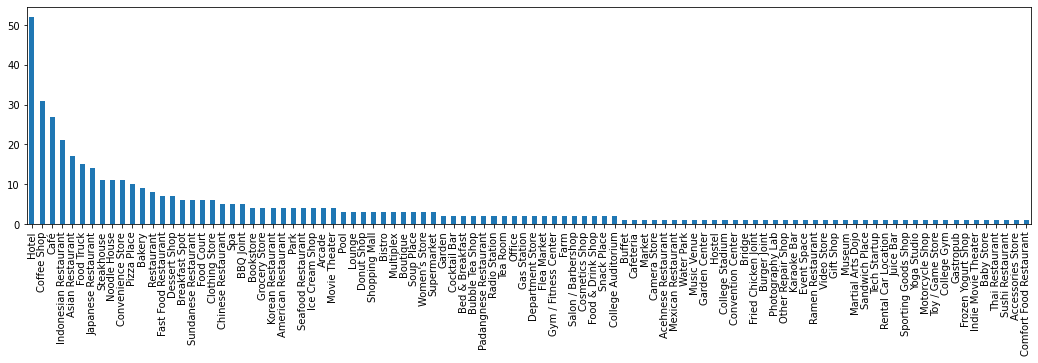

In [29]:
venues['Venue Category'].value_counts().plot(kind='bar',figsize=(18,4))

Since the categories name are not in general, so I only took the categories which contain 'restaurant', 'food', and 'drink' words for sampling

In [30]:
FnB=venues.loc[(venues['Venue Category'].str.contains('Restaurant'))|(venues['Venue Category'].str.contains('Food'))|(venues['Venue Category'].str.contains('Drink'))]
FnB

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
8,Cipaganti,-6.8867,107.6030,Soto Sulung STBA,-6.888207,107.603970,Food Truck
13,Cipaganti,-6.8867,107.6030,Matsuri Jiro,-6.883077,107.603009,Japanese Restaurant
16,Cipaganti,-6.8867,107.6030,Musouya,-6.882669,107.602498,Japanese Restaurant
18,Cipaganti,-6.8867,107.6030,Kalasan Ayam Kalasan - Mas Hadi,-6.889380,107.601271,Asian Restaurant
21,Cipaganti,-6.8867,107.6030,Mangkok Ayam,-6.882402,107.601824,Chinese Restaurant
...,...,...,...,...,...,...,...
406,Ciumbuleuit,-6.8665,107.6048,Kiputih Satu Bakery and Dine,-6.865829,107.606579,Restaurant
410,Ciumbuleuit,-6.8665,107.6048,Chef Epi,-6.867179,107.606162,Seafood Restaurant
411,Ciumbuleuit,-6.8665,107.6048,"Saung Kedjo ""Bu Ai""",-6.864002,107.605197,Sundanese Restaurant
427,Ledeng,-6.8627,107.5994,Warung Surabi Setiabudhi Bandung,-6.861133,107.595323,Food Truck


Grouped the data by the neighborhood and I got that Gegerkalong and Lebak Siliwangi have a lot of restaurants, food sellers, and drink sellers

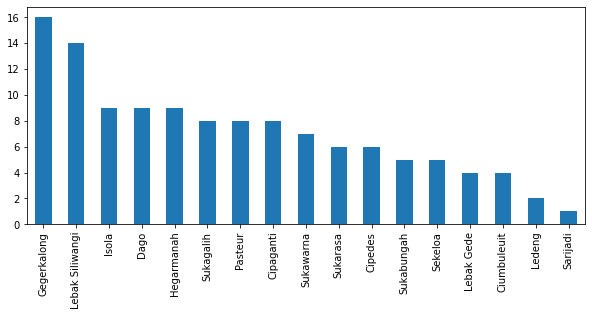

In [31]:
FnB.Neighborhood.value_counts().plot(kind='bar',figsize=(10,4))

Finally, since we want to know which neighborhood that is the nearest to ITB, and I got that Lebak Siliwangi is the nearest and It is the best location to build a dormitory house

In [46]:
ITB_near=ITB_cluster.loc[(ITB_cluster.Kelurahan=='Gegerkalong')|(ITB_cluster.Kelurahan=='Lebak Siliwangi')]
ITB_near['Distance']=np.sqrt((latitude-ITB_near['Lintang Selatan'].values)**2 + (longitude-ITB_near['Bujur Timur'].values)**2)
ITB_near

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Kelurahan,Lintang Selatan,Bujur Timur,Cluster,Distance
134,Lebak Siliwangi,-6.88499,107.61108,8,0.005669
146,Gegerkalong,-6.87480,107.59520,8,0.021877
